# Лабораторная работа №1 

**Задание:** сгенерировать временной ряд (по приложенному генератору), отрисовать, провести классические статистические тесты, разложить на компоненты, построить ACF/PACF, выбрать статистический метод моделирования и обосновать выбор, сделать прогноз на разумный период, посчитать метрики и изобразить график прогноза с учетом ошибок (доверительный интервал).

Генератор временного ряда перенесён из приложенного файла (PDF).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats
from scipy.fft import rfft, rfftfreq
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (14, 5)


In [2]:
# --- Генератор из приложенного файла (без pandas) ---
def generate_time_series(n_points=1000, has_trend=True, has_seasonality=True, seed=None):
    if seed is not None:
        np.random.seed(seed)

    start_date = datetime(2020, 1, 1)
    dates = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(n_points)]

    noise = np.random.normal(0, 5, n_points)

    trend_component = np.zeros(n_points)
    seasonal_component = np.zeros(n_points)

    if has_trend:
        trend_type = np.random.choice(['linear', 'quadratic', 'logarithmic'])
        if trend_type == 'linear':
            slope = np.random.uniform(-0.5, 0.5)
            intercept = np.random.uniform(50, 100)
            trend_component = slope * np.arange(n_points) + intercept
        elif trend_type == 'quadratic':
            a = np.random.uniform(-0.001, 0.001)
            b = np.random.uniform(-0.1, 0.1)
            c = np.random.uniform(50, 100)
            x = np.arange(n_points)
            trend_component = a * x**2 + b * x + c
        else:  # logarithmic
            a = np.random.uniform(10, 30)
            b = np.random.uniform(50, 100)
            trend_component = a * np.log(np.arange(n_points) + 1) + b

    if has_seasonality:
        n_seasons = np.random.randint(1, 4)
        for _ in range(n_seasons):
            amplitude = np.random.uniform(10, 30)
            period = np.random.uniform(30, 365)
            phase = np.random.uniform(0, 2*np.pi)
            seasonal_component += amplitude * np.sin(2*np.pi*np.arange(n_points)/period + phase)

    values = noise + trend_component + seasonal_component
    return dates, values

def dates_to_dt(dates):
    return [datetime.strptime(d, "%Y-%m-%d") for d in dates]


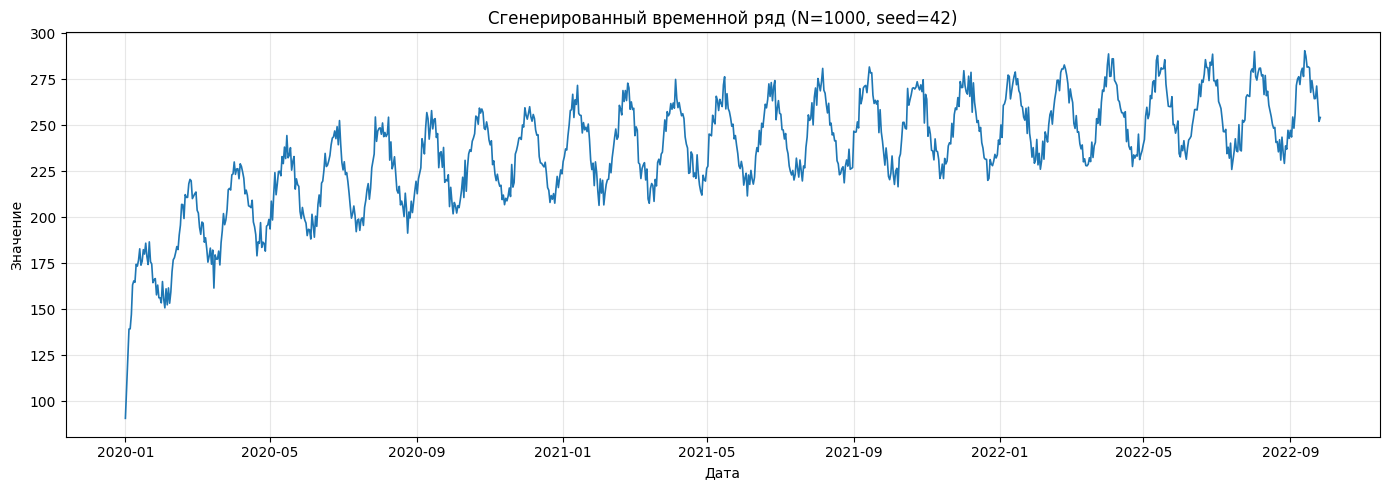

In [3]:
# 1) Генерация ряда
SEED = 42
N = 1000

dates, y = generate_time_series(n_points=N, seed=SEED)
t = dates_to_dt(dates)
y = np.asarray(y)

# 2) Визуализация
plt.figure(figsize=(14,5))
plt.plot(t, y, linewidth=1.2)
plt.title("Сгенерированный временной ряд (N=1000, seed=42)")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Классические статистические тесты

Проведём набор наиболее типичных тестов для временных рядов:

- **ADF (Augmented Dickey-Fuller)**: проверяет наличие единичного корня (нестационарность).
- **KPSS**: проверяет стационарность (обратная логика по сравнению с ADF).
- **Jarque–Bera / Shapiro–Wilk**: проверка нормальности распределения.
- **Ljung–Box**: проверка наличия автокорреляции.


In [4]:
# 3) Тесты
adf_res = adfuller(y, autolag="AIC")
kpss_res = kpss(y, regression="c", nlags="auto")

jb_stat, jb_p = stats.jarque_bera(y)
sh_stat, sh_p = stats.shapiro(y)

lb = acorr_ljungbox(y, lags=[10, 20], return_df=True)

print("ADF: stat=%.4f, p=%.6f, used_lag=%d" % (adf_res[0], adf_res[1], adf_res[2]))
print("KPSS: stat=%.4f, p=%.6f, lags=%d" % (kpss_res[0], kpss_res[1], kpss_res[2]))
print("Jarque-Bera: stat=%.4f, p=%.6e" % (jb_stat, jb_p))
print("Shapiro-Wilk: stat=%.4f, p=%.6e" % (sh_stat, sh_p))
print("Ljung-Box p-value (lags=10):", float(lb.loc[10, "lb_pvalue"]))
print("Ljung-Box p-value (lags=20):", float(lb.loc[20, "lb_pvalue"]))


ADF: stat=-4.5654, p=0.000150, used_lag=22
KPSS: stat=3.3718, p=0.010000, lags=19
Jarque-Bera: stat=164.6533, p=1.761966e-36
Shapiro-Wilk: stat=0.9630, p=3.045566e-15
Ljung-Box p-value (lags=10): 0.0
Ljung-Box p-value (lags=20): 0.0


## Разделение ряда на компоненты (STL)

Для STL нужен период сезонности. Оценим **доминирующий период** через FFT (быстро и удобно для синусоидальных компонент), затем выполним STL-разложение на:

- тренд,
- сезонность,
- остаток.


In [5]:
# 4) Оценка доминирующего периода через FFT
y_centered = y - y.mean()
n = len(y_centered)
yf = np.abs(rfft(y_centered))
xf = rfftfreq(n, d=1.0)  # циклы/день

mask = xf > 0
xf2, yf2 = xf[mask], yf[mask]
periods = 1.0 / xf2

valid = (periods >= 2) & (periods <= 365)
xfv, yfv, pv = xf2[valid], yf2[valid], periods[valid]

dominant_period = int(round(pv[np.argmax(yfv)]))
dominant_period


40

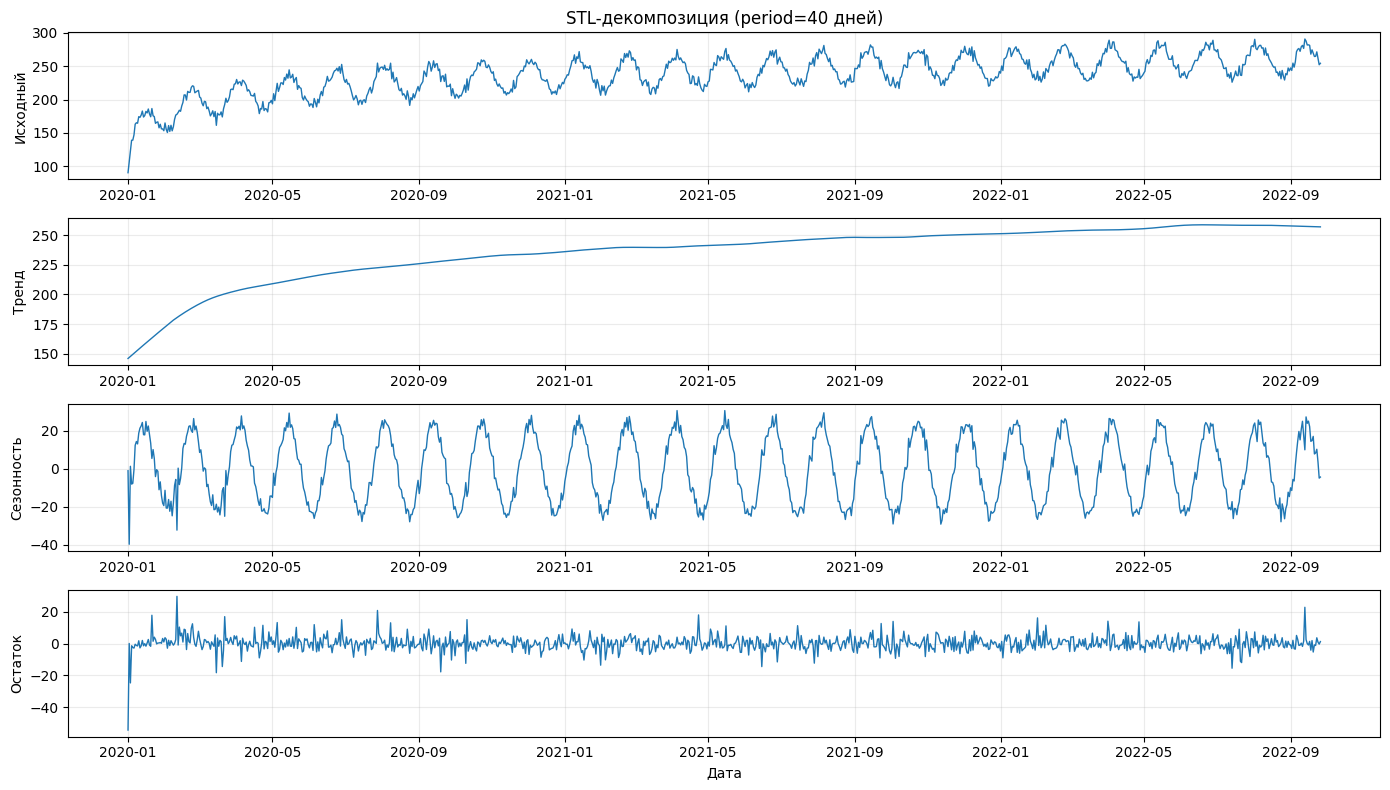

In [6]:
# 5) STL-декомпозиция
stl = STL(y, period=dominant_period, robust=True)
stl_res = stl.fit()

plt.figure(figsize=(14,8))
plt.subplot(4,1,1)
plt.plot(t, y, linewidth=1.0)
plt.title(f"STL-декомпозиция (period={dominant_period} дней)")
plt.ylabel("Исходный")
plt.grid(True, alpha=0.25)

plt.subplot(4,1,2)
plt.plot(t, stl_res.trend, linewidth=1.0)
plt.ylabel("Тренд")
plt.grid(True, alpha=0.25)

plt.subplot(4,1,3)
plt.plot(t, stl_res.seasonal, linewidth=1.0)
plt.ylabel("Сезонность")
plt.grid(True, alpha=0.25)

plt.subplot(4,1,4)
plt.plot(t, stl_res.resid, linewidth=1.0)
plt.ylabel("Остаток")
plt.xlabel("Дата")
plt.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()


## ACF/PACF

Строим автокорреляционную (ACF) и частную автокорреляционную (PACF) функции, чтобы визуально увидеть:

- наличие сезонности (пики на периоде и кратных),
- характер AR/MA компоненты (обрезание/затухание).


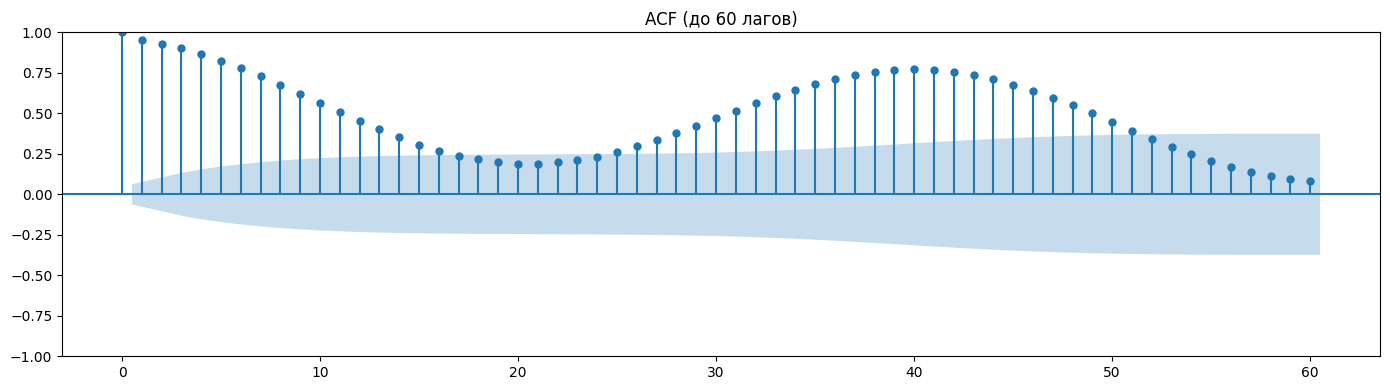

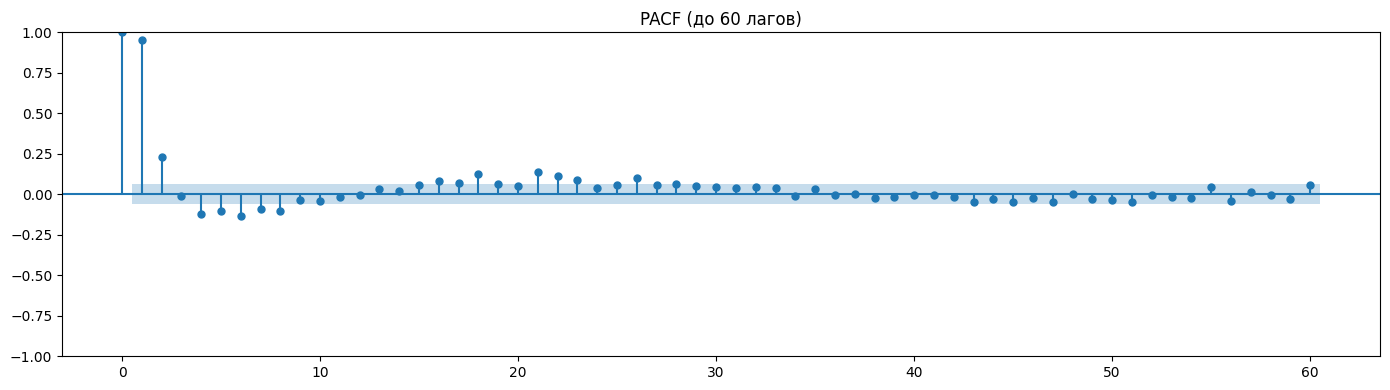

In [7]:
# 6) ACF / PACF
plt.figure(figsize=(14,4))
plot_acf(y, lags=60, ax=plt.gca())
plt.title("ACF (до 60 лагов)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,4))
plot_pacf(y, lags=60, ax=plt.gca(), method="ywm")
plt.title("PACF (до 60 лагов)")
plt.tight_layout()
plt.show()


## Выбор метода моделирования и обоснование

По графику и STL видно наличие **тренда + выраженной сезонности**, а ACF показывает **сильную автокорреляцию** и сезонный рисунок.

Поэтому выбираем **SARIMA / SARIMAX (Seasonal ARIMA)** — классическую статистическую модель, которая:
- учитывает **нестационарность** через дифференцирование,
- описывает краткосрочную зависимость через AR/MA члены,
- учитывает **сезонность** через сезонные AR/MA члены с периодом `s`.

Далее делаем hold-out (train/test), подбираем небольшой набор порядков по AIC (ограниченный грид, чтобы не ждать вечность) и считаем метрики качества на тесте.


In [8]:
# 7) Train/Test split
h_test = int(round(0.2 * len(y)))
train_y = y[:-h_test]
test_y = y[-h_test:]
train_t = t[:-h_test]
test_t = t[-h_test:]

# 8) Быстрый подбор по AIC (ограниченный грид)
s = dominant_period
p_vals = [0,1,2]
q_vals = [0,1]
P_vals = [0,1]
Q_vals = [0,1]
d = 1
D = 0

best = {"aic": np.inf, "order": None, "seasonal_order": None}
for p in p_vals:
    for q in q_vals:
        for P in P_vals:
            for Q in Q_vals:
                order = (p,d,q)
                seasonal_order = (P,D,Q,s)
                try:
                    model = SARIMAX(train_y, order=order, seasonal_order=seasonal_order,
                                    trend="n", enforce_stationarity=False, enforce_invertibility=False)
                    res = model.fit(disp=False, maxiter=50, method="lbfgs")
                    if res.aic < best["aic"]:
                        best.update({"aic": float(res.aic), "order": order, "seasonal_order": seasonal_order})
                except Exception:
                    continue

best


{'aic': 4948.307225264005, 'order': (2, 1, 1), 'seasonal_order': (1, 0, 1, 40)}

In [9]:
# 9) Обучение лучшей модели и прогноз на тест
best_order = best["order"]
best_seasonal = best["seasonal_order"]

model = SARIMAX(train_y, order=best_order, seasonal_order=best_seasonal,
                trend="n", enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False, maxiter=100, method="lbfgs")

pred = res.get_forecast(steps=len(test_y))
pred_mean = np.asarray(pred.predicted_mean)
pred_ci = np.asarray(pred.conf_int(alpha=0.05))
lower, upper = pred_ci[:,0], pred_ci[:,1]

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def smape(y_true, y_pred, eps=1e-8):
    denom = np.maximum((np.abs(y_true) + np.abs(y_pred)) / 2.0, eps)
    return float(np.mean(np.abs(y_true - y_pred) / denom) * 100.0)

metrics = {
    "MAE": mae(test_y, pred_mean),
    "RMSE": rmse(test_y, pred_mean),
    "MAPE_%": mape(test_y, pred_mean),
    "sMAPE_%": smape(test_y, pred_mean),
}
metrics


{'MAE': 7.856471162297014,
 'RMSE': 9.911798028089894,
 'MAPE_%': 3.114141593732695,
 'sMAPE_%': 3.0681406686193355}

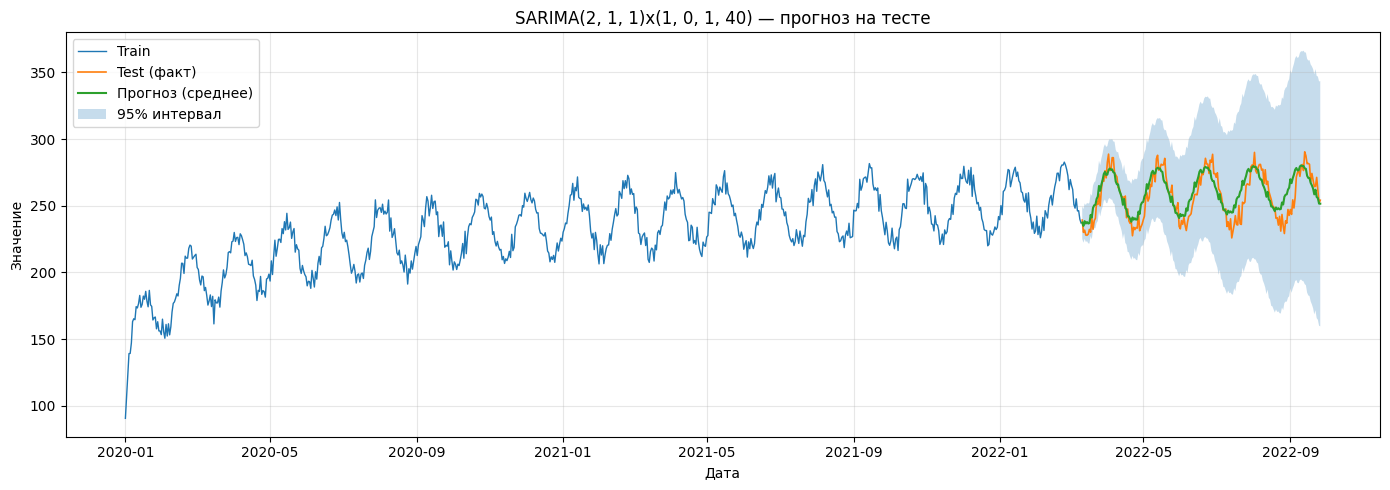

In [10]:
# 10) График прогноза на тесте с учетом ошибок (95% интервал)
plt.figure(figsize=(14,5))
plt.plot(train_t, train_y, linewidth=1.0, label="Train")
plt.plot(test_t, test_y, linewidth=1.2, label="Test (факт)")
plt.plot(test_t, pred_mean, linewidth=1.5, label="Прогноз (среднее)")
plt.fill_between(test_t, lower, upper, alpha=0.25, label="95% интервал")

plt.title(f"SARIMA{best_order}x{best_seasonal} — прогноз на тесте")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


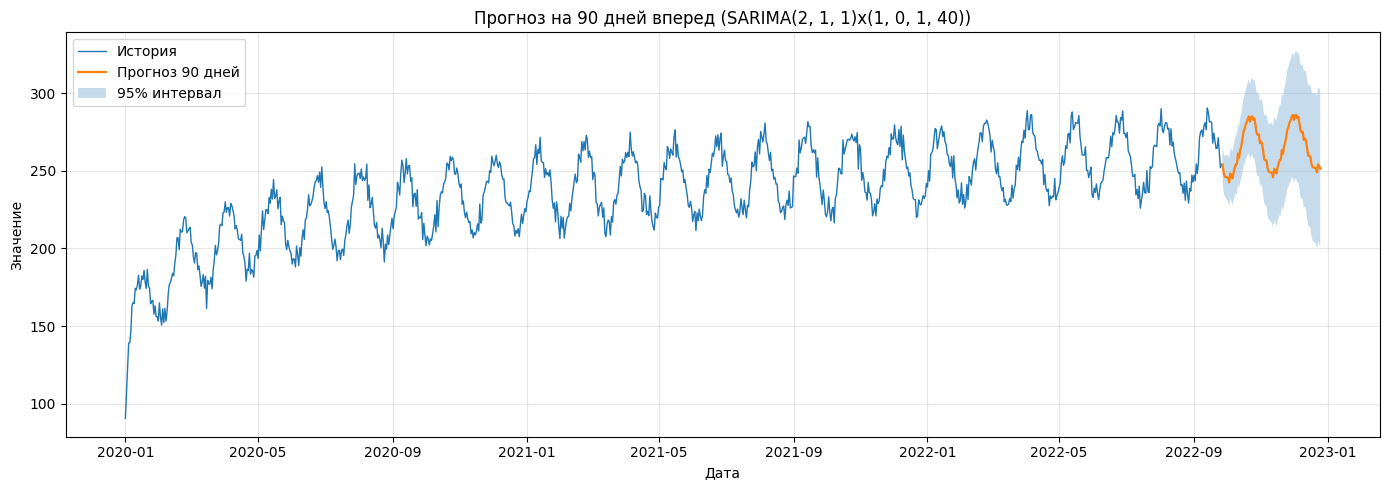

In [11]:
# 11) Прогноз на "разумный период" вперед (90 дней)
H = 90
full_model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal,
                     trend="n", enforce_stationarity=False, enforce_invertibility=False)
full_res = full_model.fit(disp=False, maxiter=100, method="lbfgs")

future = full_res.get_forecast(steps=H)
future_mean = np.asarray(future.predicted_mean)
future_ci = np.asarray(future.conf_int(alpha=0.05))
lower_f, upper_f = future_ci[:,0], future_ci[:,1]

future_dates = [t[-1] + timedelta(days=i) for i in range(1, H+1)]

plt.figure(figsize=(14,5))
plt.plot(t, y, linewidth=1.0, label="История")
plt.plot(future_dates, future_mean, linewidth=1.6, label=f"Прогноз {H} дней")
plt.fill_between(future_dates, lower_f, upper_f, alpha=0.25, label="95% интервал")

plt.title(f"Прогноз на {H} дней вперед (SARIMA{best_order}x{best_seasonal})")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
